# Extension ADA : Housing, Health and Happiness

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

%matplotlib inline
plt.rcParams.update({'font.size': 14})

from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
DATA_FOLDER = '../data/'
DATA_NAME = 'PisoFirme_AEJPol-20070024_household.dta'

data = pd.read_stata(DATA_FOLDER + DATA_NAME)

# Some informations

In [4]:
treated = data.loc[data['dpisofirme'] == 1] #People that attained the program
control = data.loc[data['dpisofirme'] == 0] #People that didn't attain the program

In [6]:
print("Treated group size : ", len(treated))
print("Control group size : ", len(control))

Treated group size :  1390
Control group size :  1393


# I. Replication of the matching of the paper

Maximum of the absolute value of differences between the following four variables for each pair of treatment and control blocks :
* C_blocksdirtfloor
* C_HHdirtfloor
* C_child05
* C_households

In [6]:
def get_max_difference(diff1, diff2, diff3, diff4):
    '''Calculate L-infifnite distance'''
    max_diff = max(abs(diff1), abs(diff2), abs(diff3), abs(diff4))
    return max_diff

In [9]:
get_max_difference(-5, 2, 1, 0.3)

5

In [10]:
# Separate the treatment and control groups
treated = data.loc[data['dpisofirme'] == 1] #People that attained the program
control = data.loc[data['dpisofirme'] == 0] #People that didn't attain the program

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        # Calculate the difference
        max_dist = get_max_difference(control_row['C_child05'] - treatment_row['C_child05'], \
                        control_row['C_blocksdirtfloor'] - treatment_row['C_blocksdirtfloor'], \
                        control_row['C_HHdirtfloor'] - treatment_row['C_HHdirtfloor'], \
                        control_row['C_households'] - treatment_row['C_households'])
        
        inv_dist = 1/max_dist
        
        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, inv_dist)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [13]:
# Matching summary

print("Number of treated households : ", len(treated))
print("Number of control households : ", len(control))
print("Number of pairs matched : ", len(matching))
print("Number of pairs NOT matched : ", len(treated)-len(matching))

Number of treated households :  1390
Number of control households :  1393
Number of pairs matched :  1187
Number of pairs NOT matched :  203


In [14]:
# Matched households
data_matched = data.iloc[[subj_id for t in matching for subj_id in t]]
data_matched.head(2)

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
973,0.0,70001889.0,-103.471283,25.570944,7.0,30,0.290323,0.049223,0.750005,836.0,...,29.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,6.214608,11.289782
2006,1.0,350002382.0,-103.378113,25.637535,35.0,48,0.560976,0.049659,0.734984,766.0,...,26.0,32.0,1.0,0.0,0.0,0.0,0.0,0.0,6.214608,8.294049


In [15]:
data_matched.shape

(2374, 78)

In [17]:
treated_matched = data_matched.loc[data_matched['dpisofirme'] == 1]
control_matched = data_matched.loc[data_matched['dpisofirme'] == 0]

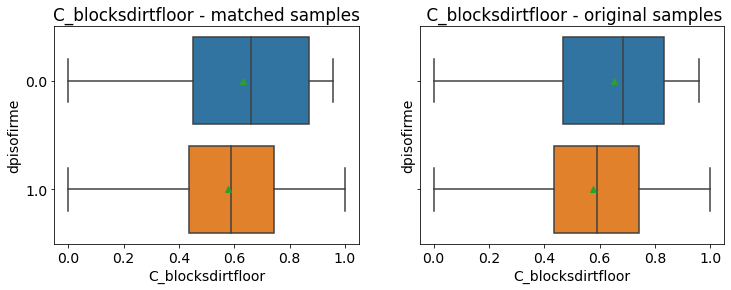

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_blocksdirtfloor'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_blocksdirtfloor - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_blocksdirtfloor'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title(' C_blocksdirtfloor - original samples');

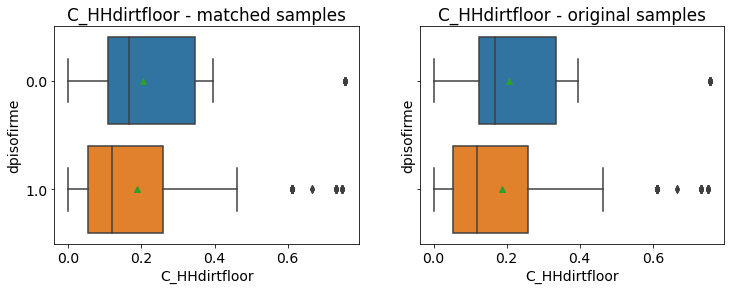

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_HHdirtfloor'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_HHdirtfloor - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_HHdirtfloor'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title('C_HHdirtfloor - original samples');

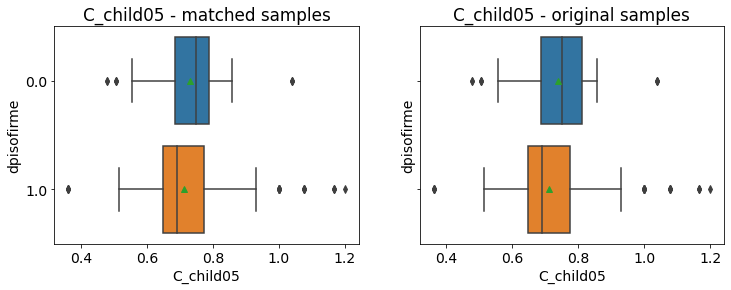

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_child05'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_child05 - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_child05'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title('C_child05 - original samples');

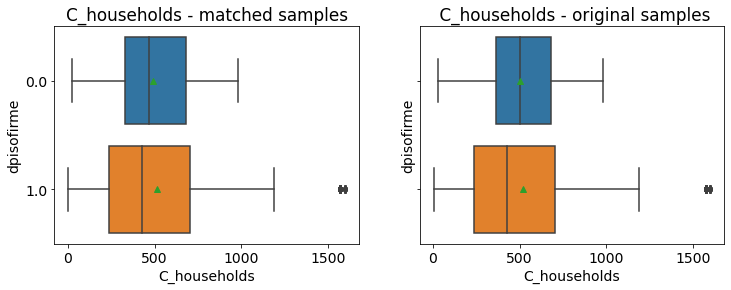

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_households'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_households - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_households'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title(' C_households - original samples');

The distributions don't change very much after the matching.

/home/louise/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/louise/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/louise/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

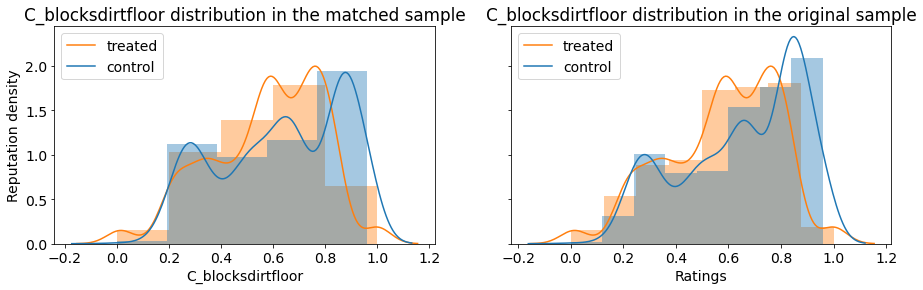

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Reputation
sns.distplot(treated_matched['C_blocksdirtfloor'], hist=True, color='tab:orange', ax=axes[0], bins=5);
sns.distplot(control_matched['C_blocksdirtfloor'], hist=True, color='tab:blue', ax=axes[0], bins=5)
axes[0].set(title='C_blocksdirtfloor distribution in the matched sample', xlabel='C_blocksdirtfloor', ylabel='Reputation density')
axes[0].legend(labels=["treated","control"])

# Ratings
sns.distplot(treated['C_blocksdirtfloor'], hist=True, color='tab:orange', ax=axes[1], bins=8);
sns.distplot(control['C_blocksdirtfloor'], hist=True, color='tab:blue', ax=axes[1], bins=8)
axes[1].set(title='C_blocksdirtfloor distribution in the original sample',xlabel='Ratings', ylabel='Ratings density')
axes[1].legend(labels=["treated","control"]);

# II. Propensity score matching

In [43]:
# Do we standardize the data ?
norm_data = (data-data.mean())/data.std()

col = data.columns.drop('dpisofirme')
variables = " + ".join(col)

# Definition of the logistic model
mod = smf.logit(formula='dpisofirme ~ C_blocksdirtfloor + C_HHdirtfloor + C_child05 + \
                                        C_households', data=data)

res = mod.fit()

# Extract the estimated propensity scores
data['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.666866
         Iterations 5


ValueError: Length of values (2580) does not match length of index (2783)

'idcluster + coord_x + coord_y + idmun + idmza + C_blocksdirtfloor + C_HHdirtfloor + C_child05 + C_households + C_people + C_rooms + C_HHpersons + C_waterland + C_waterhouse + C_waterbath + C_gasheater + C_refrigerator + C_washing + C_telephone + C_vehicle + C_overcrowding + C_poverty + C_illiterate + C_headeduc + C_dropouts515 + C_employment + C_earnincome + S_HHpeople + S_headage + S_spouseage + S_headeduc + S_spouseeduc + S_rooms + S_waterland + S_waterhouse + S_electricity + S_cementfloor2000 + S_hasanimals + S_animalsinside + S_garbage + S_washhands + S_incomepc + S_assetspc + S_shpeoplework + S_microenter + S_hrsworkedpc + S_consumptionpc + S_cashtransfers + S_milkprogram + S_foodprogram + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 + S_dem8 + S_seguropopular + S_shcementfloor + S_cementfloorkit + S_cementfloordin + S_cementfloorbat + S_cementfloorbed + S_satisfloor + S_satishouse + S_satislife + S_cesds + S_pss + S_instcement + S_instsanita + S_restsanita + S_co